# Домашнее задание к занятию 2.1: Деревья решений. Классификация

## Обзор прошедшего занятия

Что мы делали в классе:

**Задание 1**
* строили деревья
* критерии информативности которых написали даже сами
* визуализировали границы принятия решений в 2d
* и рисовали сами деревья


**Задание 2**
* приняли участие в соревновании на Kaggle, переварив кучу текстовых фичей в численные, проведя кросс-валидацию и сделав сабмит


**Задание 3**
* построили руками несколько метрик качества бинарной классификации


**Задание 4**
* использовали их для оценки классификации разделения статей Ведомостей по топикам

*дополнительно было много приятных ништяков. Например, облако слов, мультипоточность в целях парсинга, удобный инструмент для нахождения правильной css разметки, сохранение моделей в статичные файлы, разделение строк на слова и лемматизация этих слов*

## Домашнее задание

**Lvl 1:**

* взять подготовленные раннее данные из задачи **Titanic**, обучиться на них с помощью дерева решений и кросс-валидации и сделать сабмит
* кросс-валидацию желательно сделать сразу по нескольким фичам ( параметр *grid* в *GridSearchCV* )
* определить самые важные фичи
* вывести дерево решений (можете попробовать установить pydot и webgraphviz для отрисовки деревьев внутри ноутбука)

**Результат:** скрины нового сабмита на Kaggle и построенного дерева
****

In [60]:
import pandas as pd

**Сформирую тест-трейн из файлов**

In [61]:
X_train = pd.read_csv("data/titanic/train.csv")
print(X_train.shape)
X_train.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [62]:
y_train = X_train["Survived"]
del(X_train["Survived"])
print(X_train.shape)
print(y_train.shape)
y_train.head()

(891, 11)
(891,)


0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [63]:
X_test = pd.read_csv("data/titanic/test.csv")
print(X_test.shape)
X_test.head()

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [64]:
y_test = pd.read_csv("data/titanic/gender_submission.csv")["Survived"]
print(y_test.shape)
y_test.head()

(418,)


0    0
1    1
2    0
3    0
4    1
Name: Survived, dtype: int64

****
**Проведу предобработку признаков**

1) Удаляю : PassengerId — идентификатор пассажира, Name — имя пассажира, Ticket — номер билета, Cabin — каюта

2) GetDummies: Pclass — содержит социально-экономический статус: высокий, средний, низкий, Embarked — порт посадки

3) LabelEncoder: Sex — пол пассажира

4) Дополняю: Age, Fare —> NAn = mean


In [65]:
X = pd.concat([X_train, X_test])
print(X.shape)
X.info()

(1309, 11)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1046 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1308 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 122.7+ KB


In [66]:
#1 Удаляю : PassengerId — идентификатор пассажира, Name — имя пассажира, Ticket — номер билета, Cabin — каюта
X.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [67]:
X = X[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',  'Embarked']]
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [68]:
#2 GetDummies: Pclass — содержит социально-экономический статус: высокий, средний, низкий, Embarked — порт посадки
X = pd.get_dummies(X, columns = ['Pclass','Embarked'])

In [69]:
X.head()

,Sex,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,male,22.0,1,0,7.2500,0,0,1,0,0,1
1,female,38.0,1,0,71.2833,1,0,0,1,0,0
2,female,26.0,0,0,7.9250,0,0,1,0,0,1
3,female,35.0,1,0,53.1000,1,0,0,0,0,1
4,male,35.0,0,0,8.0500,0,0,1,0,0,1


In [70]:
#3 LabelEncoder: Sex — пол пассажира
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit( X['Sex'] )
X['Sex'] = le.transform( X['Sex'] )
X.head()

,Sex,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,22.0,1,0,7.2500,0,0,1,0,0,1
1,0,38.0,1,0,71.2833,1,0,0,1,0,0
2,0,26.0,0,0,7.9250,0,0,1,0,0,1
3,0,35.0,1,0,53.1000,1,0,0,0,0,1
4,1,35.0,0,0,8.0500,0,0,1,0,0,1


In [75]:
#4) Дополняю: Age, Fare —> NAn = mean
X["Age"] = X["Age"].fillna(int(X["Age"].mean()))
X["Fare"] = X["Fare"].fillna(X["Fare"].mean())
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 11 columns):
Sex           1309 non-null int32
Age           1309 non-null float64
SibSp         1309 non-null int64
Parch         1309 non-null int64
Fare          1309 non-null float64
Pclass_1      1309 non-null uint8
Pclass_2      1309 non-null uint8
Pclass_3      1309 non-null uint8
Embarked_C    1309 non-null uint8
Embarked_Q    1309 non-null uint8
Embarked_S    1309 non-null uint8
dtypes: float64(2), int32(1), int64(2), uint8(6)
memory usage: 63.9 KB


In [80]:
X_train = X[:891]
X_test = X[891:]
print(X_train.shape)
print(X_test.shape)

(891, 11)
(418, 11)


****
**Обучу дерево и предскажу результат**

In [82]:
from sklearn.tree import DecisionTreeClassifier

In [83]:
model = DecisionTreeClassifier(max_depth=10)

In [84]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [89]:
y_pred

array([0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,

In [85]:
model.score(X_test, y_test)

0.8110047846889952

In [98]:
Result = pd.read_csv("data/titanic/gender_submission.csv")
Result["Survived"] = y_pred
Result.to_csv("data/titanic/MyResult_1.csv", index = False)

<img src="data/titanic/My_result_1.PNG">

In [101]:
# Уберу макс. глубину
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
Result["Survived"] = y_pred
Result.to_csv("data/titanic/MyResult_2.csv", index = False)

<img src="data/titanic/My_result_2.PNG">

Как делать кросс-валидацию, не смогла разобраться..

([<matplotlib.axis.YTick at 0x1c7cff03f60>,
 <a list of 11 Text yticklabel objects>)

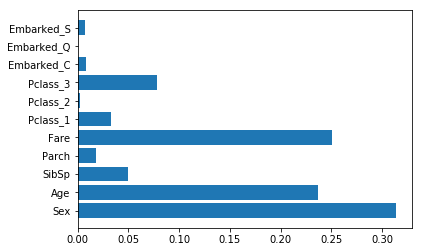

In [104]:
#Посмотрю важность фичей
from matplotlib import pyplot as plt
import numpy as np
plt.barh(np.arange(len(model.feature_importances_)), model.feature_importances_)
plt.yticks(np.arange(len(X.columns)),X.columns)

In [105]:
#Визуализация дерева
from sklearn.tree import export_graphviz

def get_tree_dot_view(model, feature_names=None, class_names=None):
    print(export_graphviz(model, out_file=None, filled=True, feature_names=feature_names, class_names=class_names))

In [107]:
get_tree_dot_view(model)

digraph Tree {
node [shape=box, style="filled", color="black"] ;
0 [label="X[0] <= 0.5\ngini = 0.473\nsamples = 891\nvalue = [549, 342]", fillcolor="#e5813960"] ;
1 [label="X[7] <= 0.5\ngini = 0.383\nsamples = 314\nvalue = [81, 233]", fillcolor="#399de5a6"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="X[1] <= 2.5\ngini = 0.1\nsamples = 170\nvalue = [9, 161]", fillcolor="#399de5f1"] ;
1 -> 2 ;
3 [label="X[5] <= 0.5\ngini = 0.5\nsamples = 2\nvalue = [1, 1]", fillcolor="#e5813900"] ;
2 -> 3 ;
4 [label="gini = 0.0\nsamples = 1\nvalue = [0, 1]", fillcolor="#399de5ff"] ;
3 -> 4 ;
5 [label="gini = 0.0\nsamples = 1\nvalue = [1, 0]", fillcolor="#e58139ff"] ;
3 -> 5 ;
6 [label="X[4] <= 28.856\ngini = 0.091\nsamples = 168\nvalue = [8, 160]", fillcolor="#399de5f2"] ;
2 -> 6 ;
7 [label="X[4] <= 28.231\ngini = 0.182\nsamples = 69\nvalue = [7, 62]", fillcolor="#399de5e2"] ;
6 -> 7 ;
8 [label="X[1] <= 56.0\ngini = 0.161\nsamples = 68\nvalue = [6, 62]", fillcolor="#399de5e6

**Lvl 2:** (опционально)

* С помощью функций sklearn.metrics.auc, precision, recall составить функцию для расчёта ROC-AUC, ROC-PRC
* Придумать себе интересную задачу на основе данных из интернета =) Спарсить ещё какой-нибудь сайт (не Ведомости) и решить задачу классификации. Делать свои проекты - круто. Если будут - кидайте мне =) [@NikitaKuznetsov](http://t.me/NikitaKuznesov)